In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls

--2023-04-22 13:32:56--  https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5539328 (5.3M) [application/x-httpd-php]
Saving to: ‘default of credit card clients.xls’

default of credit c 100%[===================>]   5.28M  12.6MB/s    in 0.4s    

2023-04-22 13:32:57 (12.6 MB/s) - ‘default of credit card clients.xls’ saved [5539328/5539328]



**Import library**

In [ ]:
import numpy as np
import pandas as pd
import sklearn
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, auc, roc_curve, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
#library for oversampling dataset
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE, SMOTENC, ADASYN
#plot
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
#feature selection
import sklearn.feature_selection

#model selection
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import xgboost as xgb

In [ ]:
df = pd.read_excel("./default of credit card clients.xls", header=1, index_col=0)
df.head(10)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
6,50000,1,1,2,37,0,0,0,0,0,...,19394,19619,20024,2500,1815,657,1000,1000,800,0
7,500000,1,1,2,29,0,0,0,0,0,...,542653,483003,473944,55000,40000,38000,20239,13750,13770,0
8,100000,2,2,2,23,0,-1,-1,0,0,...,221,-159,567,380,601,0,581,1687,1542,0
9,140000,2,3,1,28,0,0,2,0,0,...,12211,11793,3719,3329,0,432,1000,1000,1000,0


In [ ]:
feature = ['LIMIT_BAL', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT4', 'PAY_AMT3', 'PAY_AMT5', 'PAY_AMT6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5','default payment next month']

In [ ]:
df = df[feature]

**Util Function**

In [ ]:
def calculate_metrics(model, X_test_scaled, Y_test):
    # Get model predictions
    y_predict_r = model.predict(X_test_scaled)
    
    # Calculate evaluation metrics for assesing performance of the model.
    roc=roc_auc_score(Y_test, y_predict_r)
    acc = accuracy_score(Y_test, y_predict_r)
    prec = precision_score(Y_test, y_predict_r)
    rec = recall_score(Y_test, y_predict_r)
    f1 = f1_score(Y_test, y_predict_r)
    
    return acc, roc, prec, rec, f1

def train_and_get_metrics(model, X_train, Y_train, X_test, Y_test):

    # All features of dataset are float values. You normalize all features of the train and test dataset here.
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Call the fit model function to train the model on the normalized features and the diagnosis values
    model = model.fit(X_train_scaled, Y_train)

    # Make predictions on test dataset and calculate metrics.
    roc, acc, prec, rec, f1 = calculate_metrics(model, X_test_scaled, Y_test)

    display_df = pd.DataFrame([[acc, roc, prec, rec, f1, X_test_scaled.shape[1]]], columns=["Accuracy", "ROC", "Precision", "Recall", "F1 Score", 'Feature Count'])
    
    return display_df

     

#Performance evaluation
def plot_roc_curve(model,X_test,Y_test):
    Y_predict = model.predict(X_test)
    print(classification_report(Y_test, Y_predict))
    fpr, tpr, thres = roc_curve(Y_test, Y_predict)
    _plot_roc_curve(fpr, tpr, thres) 

def multi_model_train_and_test(model, X_train, Y_train, X_test, Y_test):
    model.fit(X_train, Y_train)
    predictions = model.predict_proba(X_test)
    pred_label = model.predict(X_test) 

    # Calculate evaluation metrics for assesing performance of the model.
    roc=roc_auc_score(Y_test, predictions[:,1])
    acc = accuracy_score(Y_test, pred_label)
    prec = precision_score(Y_test, pred_label)
    rec = recall_score(Y_test, pred_label)
    f1 = f1_score(Y_test, pred_label)
    
    display_df = pd.DataFrame([[acc, roc, prec, rec, f1, X_train.shape[1]]], columns=["Accuracy", "ROC", "Precision", "Recall", "F1 Score", 'Feature Count'])
    return display_df

def _plot_roc_curve(fpr, tpr, thres):
    roc = plt.figure(figsize = (10, 8))
    plt.plot(fpr, tpr, 'b-', label = 'ROC')
    plt.plot([0, 1], [0, 1], '--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   LIMIT_BAL                   30000 non-null  int64
 1   PAY_AMT1                    30000 non-null  int64
 2   PAY_AMT2                    30000 non-null  int64
 3   PAY_AMT4                    30000 non-null  int64
 4   PAY_AMT3                    30000 non-null  int64
 5   PAY_AMT5                    30000 non-null  int64
 6   PAY_AMT6                    30000 non-null  int64
 7   BILL_AMT1                   30000 non-null  int64
 8   BILL_AMT2                   30000 non-null  int64
 9   BILL_AMT3                   30000 non-null  int64
 10  PAY_0                       30000 non-null  int64
 11  PAY_2                       30000 non-null  int64
 12  PAY_3                       30000 non-null  int64
 13  PAY_4                       30000 non-null  int64
 14  PAY_5 

0    23364
1     6636
Name: default payment next month, dtype: int64


<Axes: >

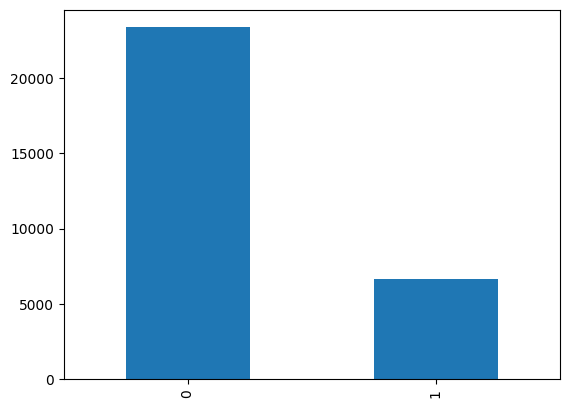

In [ ]:
print(df['default payment next month'].value_counts())
df['default payment next month'].value_counts().plot(kind='bar')

In [ ]:
#transform to consistency data
for i in range(0,6):
    if i == 1: continue
    Pay_dict = {ele:i for i,ele in enumerate(df["PAY_{}".format(i)].value_counts().keys())}
    df["PAY_{}".format(i)] = df["PAY_{}".format(i)].map(Pay_dict)

**Split dataset -> train/val/test**

In [ ]:
#8:1:1
features = list(set(df.columns).difference({"default payment next month"}))
target = ["default payment next month"]
y = df[target]

In [ ]:
#split id
id_pos = np.where(y.values.reshape(-1) == 0)[0]
id_neg = np.where(y.values.reshape(-1) == 1)[0]

#shuffle id
np.random.shuffle(id_pos)
np.random.shuffle(id_neg)

#train
id_train_neg = id_neg[:int(len(id_neg) * 0.8)]
id_train_pos = id_pos[:int(len(id_pos) * 0.8)]
id_train = np.concatenate((id_train_neg, id_train_pos), axis = 0)

#val
id_val_neg = id_neg[int(len(id_neg) * 0.8):int(len(id_neg) * 0.9)]
id_val_pos = id_pos[int(len(id_pos) * 0.8):int(len(id_pos) * 0.9)]
id_val = np.concatenate((id_val_neg, id_val_pos), axis = 0)

#test
id_test_neg = id_neg[int(len(id_neg) * 0.9):]
id_test_pos = id_pos[int(len(id_pos) * 0.9):]
id_test = np.concatenate((id_test_neg, id_test_pos), axis = 0)

In [ ]:
# create dataste
data_train = df.iloc[id_train]
data_val = df.iloc[id_val]
data_test = df.iloc[id_test]


print("data_train has shape: ",data_train.shape)
print("data_val has shape: ",data_val.shape)
print("data_test has shape: ",data_test.shape)

data_train has shape:  (23999, 16)
data_val has shape:  (3000, 16)
data_test has shape:  (3001, 16)


**Grid Search to find suitable parameter for baseline model**

In [ ]:
pipeline = Pipeline([
    ('scaler', StandardScaler()), # các bước tiền xử lý dữ liệu (nếu có)
    ('classifier', RandomForestClassifier()) # mô hình huấn luyện
])

params = {
    'classifier__n_estimators': [100, 500, 800],
    'classifier__max_depth': [5, 10],
    'classifier__min_samples_split': [200, 400],
    'classifier__class_weight' : [None,"balanced"],
    'classifier__max_features' : [10,"auto","sqrt"]
}

grid_search = GridSearchCV(pipeline, params, cv=5, scoring='f1')
grid_search.fit(data_train[features], data_train[target].values.ravel())

/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForest

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier',
                                        RandomForestClassifier())]),
             param_grid={'classifier__class_weight': [None, 'balanced'],
                         'classifier__max_depth': [5, 10],
                         'classifier__max_features': [10, 'auto', 'sqrt'],
                         'classifier__min_samples_split': [200, 400],
                         'classifier__n_estimators': [100, 500, 800]},
             scoring='f1')

In [ ]:
print("Best parameters: ", grid_search.best_params_)
print("Best F1-score: ", grid_search.best_score_)
print("Test F1-score: ", grid_search.score(data_val[features], data_val[target].values.ravel()))

Best parameters:  {'classifier__class_weight': 'balanced', 'classifier__max_depth': 10, 'classifier__max_features': 'auto', 'classifier__min_samples_split': 200, 'classifier__n_estimators': 500}
Best F1-score:  0.5427378154374232
Test F1-score:  0.5448634590377113


In [ ]:
model_baseline = RandomForestClassifier(n_estimators=500, 
                                max_depth=10, 
                                min_samples_split=200, 
                                random_state=12, 
                                class_weight="balanced",
                                max_features="auto")

In [ ]:
results = pd.DataFrame({})

In [ ]:
all_features_eval_df = train_and_get_metrics(model_baseline,data_train[features], data_train[target].values.ravel(),data_test[features], data_test[target].values.ravel())
all_features_eval_df.index = ['baseline']
all_features_eval_df["Description"] = ""

results = results.append(all_features_eval_df)
results.tail()

/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
<ipython-input-67-4dd57708cb80>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(all_features_eval_df)


,Accuracy,ROC,Precision,Recall,F1 Score,Feature Count,Description
penalty_method3,0.705695,0.738087,0.437882,0.647590,0.522479,15,"0: 0.2, 1: 0.8"
linear_gradient_boosting_method,0.700665,0.752083,0.454955,0.608434,0.520619,15,
linear_gradient_boosting_method1,0.707201,0.738754,0.439024,0.650602,0.524272,15,"0: 0.2, 1 : 0.8"
xgboost_method,0.633073,0.793735,0.554479,0.344880,0.425255,15,
baseline,0.709634,0.769410,0.483092,0.602410,0.536193,15,


**Undersampling method**
*   70:30
*   60:40
*   50:50
Note: Less data may cause overfiting

In [ ]:
print(len(id_train_pos)/30000 * 100)
print(len(id_train_neg)/30000 * 100)

62.303333333333335
17.69333333333333


get ratio pos/neg == 30/70

In [ ]:
# len(id_train_neg) = 5308
# to find len(neg) = x:
# to get ratio 30/70: => 5308/(x + 5308) = 0.3 => x = 12835
np.random.shuffle(id_train_pos)
id_train_pos_30_70 = id_train_pos[:12835]
id_train_30_70 = np.concatenate((id_train_pos_30_70, id_train_neg), axis = 0)

get ratio pos/neg == 40/60

In [ ]:
# len(id_train_neg) = 5308
# to find len(neg) = x:
# to get ratio 30/70: => 5308/(x + 5308) = 0.4 => x = 7962
np.random.shuffle(id_train_pos)
id_train_pos_40_60 = id_train_pos[:7962]
id_train_40_60 = np.concatenate((id_train_pos_40_60, id_train_neg), axis = 0)

get ratio pos/neg == 50/50

In [ ]:
# len(id_train_neg) = 5308
# to find len(neg) = x:
# to get ratio 30/70: => 5308/(x + 5308) = 0.4 => x = 5308
np.random.shuffle(id_train_pos)
id_train_pos_50_50 = id_train_pos[:5308]
id_train_50_50 = np.concatenate((id_train_pos_50_50, id_train_neg), axis = 0)

In [ ]:
data_train_30_70 = df.iloc[id_train_30_70]
data_train_40_60 = df.iloc[id_train_40_60]
data_train_50_50 = df.iloc[id_train_50_50]

In [ ]:
under_sampling_30_70 = train_and_get_metrics(model_baseline,data_train_30_70[features], data_train_30_70[target].values.ravel(),data_test[features], data_test[target].values.ravel())
under_sampling_40_60 = train_and_get_metrics(model_baseline,data_train_40_60[features], data_train_40_60[target].values.ravel(),data_test[features], data_test[target].values.ravel())
under_sampling_50_50 = train_and_get_metrics(model_baseline,data_train_50_50[features], data_train_50_50[target].values.ravel(),data_test[features], data_test[target].values.ravel())

/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForest

In [ ]:
all_features_eval_df = under_sampling_30_70
all_features_eval_df.index = ['under_sampling_30_70']
all_features_eval_df["Description"] = ""

results = results.append(all_features_eval_df)
results.head(10)

<ipython-input-49-2733b98ae3d1>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(all_features_eval_df)


,Accuracy,ROC,Precision,Recall,F1 Score,Feature Count,Description
under_sampling_30_70,0.70966,0.764412,0.474854,0.611446,0.534562,15,


In [ ]:
all_features_eval_df = under_sampling_40_60
all_features_eval_df.index = ['under_sampling_40_60']
all_features_eval_df["Description"] = ""

results = results.append(all_features_eval_df)
results.head(10)

<ipython-input-50-d496481a0587>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(all_features_eval_df)


,Accuracy,ROC,Precision,Recall,F1 Score,Feature Count,Description
under_sampling_30_70,0.709660,0.764412,0.474854,0.611446,0.534562,15,
under_sampling_40_60,0.710207,0.762746,0.472286,0.615964,0.534641,15,


In [ ]:
all_features_eval_df = under_sampling_50_50
all_features_eval_df.index = ['under_sampling_50_50']
all_features_eval_df["Description"] = ""

results = results.append(all_features_eval_df)
results.head(10)

<ipython-input-51-0d884a3a7cb0>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(all_features_eval_df)


,Accuracy,ROC,Precision,Recall,F1 Score,Feature Count,Description
under_sampling_30_70,0.709660,0.764412,0.474854,0.611446,0.534562,15,
under_sampling_40_60,0.710207,0.762746,0.472286,0.615964,0.534641,15,
under_sampling_50_50,0.708307,0.754748,0.460089,0.625000,0.530013,15,


**Oversampling method**

In [ ]:
#Naive random over-sampling
naive_random_oversampling = make_pipeline(RandomOverSampler(sampling_strategy=1, random_state=0), model_baseline)
NAIVE_RANDOM_O = train_and_get_metrics(naive_random_oversampling,data_train[features], data_train[target].values.ravel(),data_test[features], data_test[target].values.ravel())

/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


In [ ]:
all_features_eval_df = NAIVE_RANDOM_O 
all_features_eval_df.index = ['naive_random_oversampling']
all_features_eval_df["Description"] = ""

results = results.append(all_features_eval_df)
results.tail()

<ipython-input-56-bb57f8eb698a>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(all_features_eval_df)


,Accuracy,ROC,Precision,Recall,F1 Score,Feature Count,Description
under_sampling_30_70,0.709660,0.764412,0.474854,0.611446,0.534562,15,
under_sampling_40_60,0.710207,0.762746,0.472286,0.615964,0.534641,15,
under_sampling_50_50,0.708307,0.754748,0.460089,0.625000,0.530013,15,
naive_random_oversampling,0.708890,0.767411,0.479665,0.603916,0.534667,15,


**Smote**

In [ ]:
smotes = {0 : 'SMOTE',
          1 : 'BorderlineSMOTE',
          2 : 'SVMSMOTE',
          3 : 'ADASYN'}

methods = [
    SMOTE(sampling_strategy = 1, random_state=0),
    BorderlineSMOTE(sampling_strategy = 1, random_state=0, kind='borderline-1'),
    SVMSMOTE(sampling_strategy = 1, random_state=0),
    ADASYN(sampling_strategy = 1, random_state=0)
]

for i,method in enumerate(methods):
    smote_random_oversampling_model = make_pipeline(method, model_baseline)
    SMOTE_RO = train_and_get_metrics(smote_random_oversampling_model,data_train[features], data_train[target].values.ravel(),data_test[features], data_test[target].values.ravel())
    all_features_eval_df = SMOTE_RO
    all_features_eval_df.index = [smotes[i]]
    all_features_eval_df["Description"] = ""

    results = results.append(all_features_eval_df)

results.tail()

/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
<ipython-input-59-f7d93e25f1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(all_features_eval_df)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
<ipython-input-59-f7d93e25f1ed>:20: FutureWarning: The frame.append method is deprec

,Accuracy,ROC,Precision,Recall,F1 Score,Feature Count,Description
naive_random_oversampling,0.708890,0.767411,0.479665,0.603916,0.534667,15,
SMOTE,0.714469,0.772742,0.489130,0.609940,0.542895,15,
BorderlineSMOTE,0.706182,0.727091,0.425695,0.668675,0.520211,15,
SVMSMOTE,0.713930,0.772742,0.489104,0.608434,0.542282,15,
ADASYN,0.699193,0.744752,0.444685,0.617470,0.517024,15,


**Punish Model**

In [ ]:
model_pen = RandomForestClassifier(n_estimators=500, 
                                max_depth=10, 
                                min_samples_split=400, 
                                random_state=12, 
                                class_weight={0: 0.1,
                                              1: 0.9},
                                max_features="auto")

penalty_method = train_and_get_metrics(model_pen,data_train[features], data_train[target].values.ravel(),data_test[features], data_test[target].values.ravel())
all_features_eval_df = penalty_method
all_features_eval_df.index = ["penalty_method1"]
all_features_eval_df["Description"] = "0: 0.1, 1: 0.9"
results = results.append(all_features_eval_df)

results.tail()

/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
<ipython-input-61-4a3ea518ca9b>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(all_features_eval_df)


,Accuracy,ROC,Precision,Recall,F1 Score,Feature Count,Description
SMOTE,0.714469,0.772742,0.489130,0.609940,0.542895,15,
BorderlineSMOTE,0.706182,0.727091,0.425695,0.668675,0.520211,15,
SVMSMOTE,0.713930,0.772742,0.489104,0.608434,0.542282,15,
ADASYN,0.699193,0.744752,0.444685,0.617470,0.517024,15,
penalty_method1,0.636146,0.482839,0.288370,0.911145,0.438088,15,"0: 0.1, 1: 0.9"


In [ ]:
model_pen2 = RandomForestClassifier(n_estimators=500, 
                                max_depth=10, 
                                min_samples_split=400, 
                                random_state=12, 
                                class_weight={0: 0.3,
                                              1: 0.7},
                                max_features="auto")

penalty_method = train_and_get_metrics(model_pen2,data_train[features], data_train[target].values.ravel(),data_test[features], data_test[target].values.ravel())
all_features_eval_df = penalty_method
all_features_eval_df.index = ["penalty_method2"]
all_features_eval_df["Description"] = "0: 0.3, 1: 0.7"
results = results.append(all_features_eval_df)

results.tail()

/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
<ipython-input-62-65c7145dc676>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(all_features_eval_df)


,Accuracy,ROC,Precision,Recall,F1 Score,Feature Count,Description
BorderlineSMOTE,0.706182,0.727091,0.425695,0.668675,0.520211,15,
SVMSMOTE,0.713930,0.772742,0.489104,0.608434,0.542282,15,
ADASYN,0.699193,0.744752,0.444685,0.617470,0.517024,15,
penalty_method1,0.636146,0.482839,0.288370,0.911145,0.438088,15,"0: 0.1, 1: 0.9"
penalty_method2,0.701826,0.800067,0.550473,0.525602,0.537750,15,"0: 0.3, 1: 0.7"


In [ ]:
model_pen2 = RandomForestClassifier(n_estimators=500, 
                                max_depth=10, 
                                min_samples_split=400, 
                                random_state=12, 
                                class_weight={0: 0.2,
                                              1: 0.8},
                                max_features="auto")

penalty_method = train_and_get_metrics(model_pen2,data_train[features], data_train[target].values.ravel(),data_test[features], data_test[target].values.ravel())
all_features_eval_df = penalty_method
all_features_eval_df.index = ["penalty_method3"]
all_features_eval_df["Description"] = "0: 0.2, 1: 0.8"
results = results.append(all_features_eval_df)

results.tail()

/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
<ipython-input-63-dfc571d7311c>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(all_features_eval_df)


,Accuracy,ROC,Precision,Recall,F1 Score,Feature Count,Description
SVMSMOTE,0.713930,0.772742,0.489104,0.608434,0.542282,15,
ADASYN,0.699193,0.744752,0.444685,0.617470,0.517024,15,
penalty_method1,0.636146,0.482839,0.288370,0.911145,0.438088,15,"0: 0.1, 1: 0.9"
penalty_method2,0.701826,0.800067,0.550473,0.525602,0.537750,15,"0: 0.3, 1: 0.7"
penalty_method3,0.705695,0.738087,0.437882,0.647590,0.522479,15,"0: 0.2, 1: 0.8"


**Use other some non-parametric model**

Linear Gradient Boosting

In [ ]:
lgb_classifier = lgb.LGBMClassifier(n_estimator = 800, 
                                    objective = 'binary', 
                                    class_weight = {
                                        0 : 0.2,
                                        1 : 0.8
                                    },
                                    learning_rate = 0.1,
                                    reg_alpha = 0.1,
                                    reg_lambda = 0.1,
                                    subsample = 0.8,
                                    n_job = -1,
                                    random_state = 12
                                   )

lgb_method = train_and_get_metrics(lgb_classifier,data_train[features], data_train[target],data_test[features], data_test[target])
all_features_eval_df = lgb_method
all_features_eval_df.index = ["linear_gradient_boosting_method1"]
all_features_eval_df["Description"] = "0: 0.2, 1 : 0.8"
results = results.append(all_features_eval_df)
results.tail()

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Unknown parameter: n_job
[LightGBM] [Warning] Unknown parameter: n_estimator


<ipython-input-65-468c2b58d448>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(all_features_eval_df)


,Accuracy,ROC,Precision,Recall,F1 Score,Feature Count,Description
penalty_method1,0.636146,0.482839,0.288370,0.911145,0.438088,15,"0: 0.1, 1: 0.9"
penalty_method2,0.701826,0.800067,0.550473,0.525602,0.537750,15,"0: 0.3, 1: 0.7"
penalty_method3,0.705695,0.738087,0.437882,0.647590,0.522479,15,"0: 0.2, 1: 0.8"
linear_gradient_boosting_method,0.700665,0.752083,0.454955,0.608434,0.520619,15,
linear_gradient_boosting_method1,0.707201,0.738754,0.439024,0.650602,0.524272,15,"0: 0.2, 1 : 0.8"


xg_boost

In [ ]:
model_xgb = xgb.XGBClassifier(random_state=42, n_estimators = 800)
xgb_method = train_and_get_metrics(model_xgb,data_train[features], data_train[target],data_test[features], data_test[target])
all_features_eval_df = xgb_method
all_features_eval_df.index = ["xgboost_method"]
all_features_eval_df["Description"] = ""
results = results.append(all_features_eval_df)
results.tail()

<ipython-input-66-0fcf75322ebc>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(all_features_eval_df)


,Accuracy,ROC,Precision,Recall,F1 Score,Feature Count,Description
penalty_method2,0.701826,0.800067,0.550473,0.525602,0.537750,15,"0: 0.3, 1: 0.7"
penalty_method3,0.705695,0.738087,0.437882,0.647590,0.522479,15,"0: 0.2, 1: 0.8"
linear_gradient_boosting_method,0.700665,0.752083,0.454955,0.608434,0.520619,15,
linear_gradient_boosting_method1,0.707201,0.738754,0.439024,0.650602,0.524272,15,"0: 0.2, 1 : 0.8"
xgboost_method,0.633073,0.793735,0.554479,0.344880,0.425255,15,


In [ ]:
results

,Accuracy,ROC,Precision,Recall,F1 Score,Feature Count,Description
under_sampling_30_70,0.709660,0.764412,0.474854,0.611446,0.534562,15,
under_sampling_40_60,0.710207,0.762746,0.472286,0.615964,0.534641,15,
under_sampling_50_50,0.708307,0.754748,0.460089,0.625000,0.530013,15,
naive_random_oversampling,0.708890,0.767411,0.479665,0.603916,0.534667,15,
SMOTE,0.714469,0.772742,0.489130,0.609940,0.542895,15,
BorderlineSMOTE,0.706182,0.727091,0.425695,0.668675,0.520211,15,
SVMSMOTE,0.713930,0.772742,0.489104,0.608434,0.542282,15,
ADASYN,0.699193,0.744752,0.444685,0.617470,0.517024,15,
penalty_method1,0.636146,0.482839,0.288370,0.911145,0.438088,15,"0: 0.1, 1: 0.9"
penalty_method2,0.701826,0.800067,0.550473,0.525602,0.537750,15,"0: 0.3, 1: 0.7"


Choose 2 model: SMOTE, penalty_method2, some inside to plot this

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.87      0.70      0.78      2337
           1       0.38      0.64      0.47       664

    accuracy                           0.69      3001
   macro avg       0.62      0.67      0.63      3001
weighted avg       0.76      0.69      0.71      3001



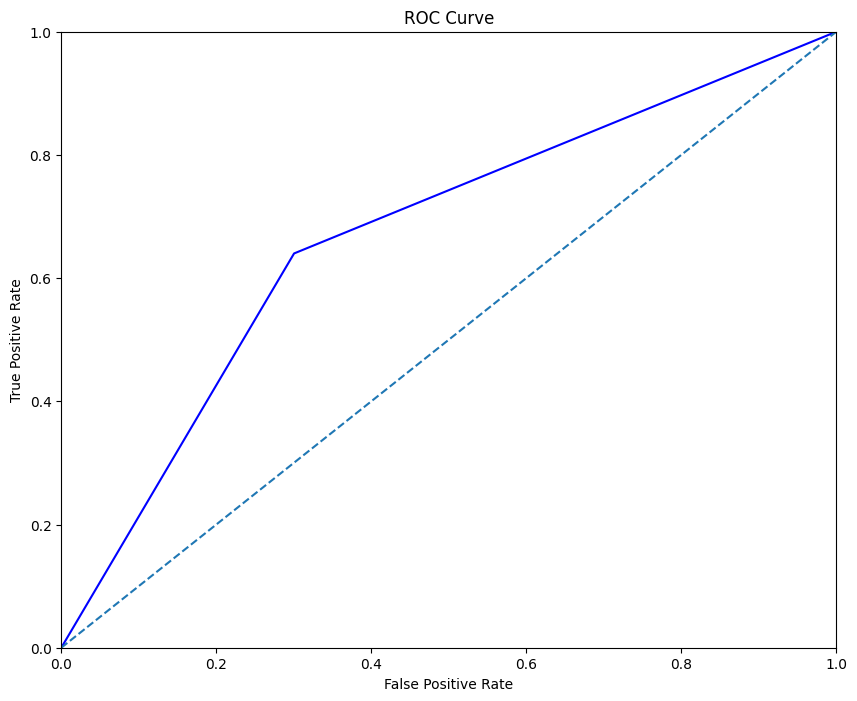

In [ ]:
plot_roc_curve(model_pen2,data_test[features], data_test[target].values.ravel())

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.84      0.79      0.82      2337
           1       0.40      0.48      0.44       664

    accuracy                           0.72      3001
   macro avg       0.62      0.64      0.63      3001
weighted avg       0.74      0.72      0.73      3001



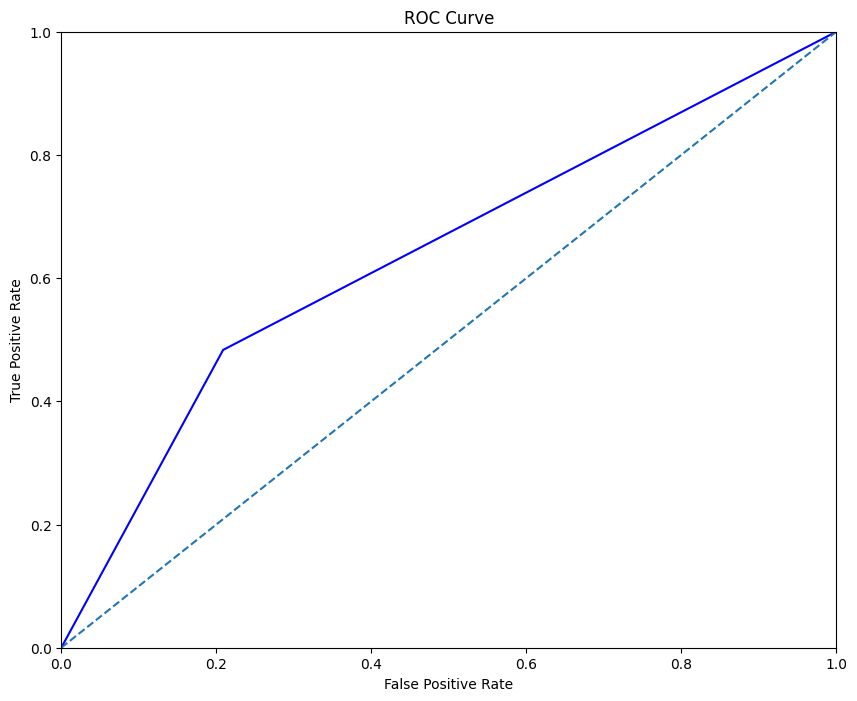

In [ ]:
smote_random_oversampling_model = make_pipeline(SMOTE(sampling_strategy = 1, random_state=0), model_baseline)
plot_roc_curve(smote_random_oversampling_model,data_test[features], data_test[target].values.ravel())

**Use some non-tree based model**

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision an

              precision    recall  f1-score   support

           0       0.78      1.00      0.88      2337
           1       0.00      0.00      0.00       664

    accuracy                           0.78      3001
   macro avg       0.39      0.50      0.44      3001
weighted avg       0.61      0.78      0.68      3001



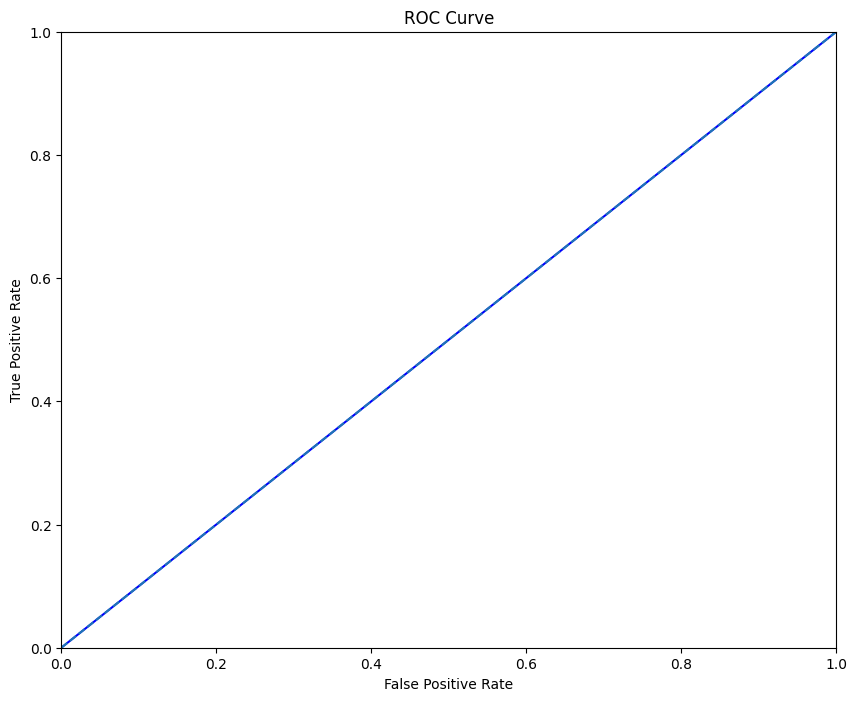

In [ ]:
#logistic Regression
feature_choose = ['LIMIT_BAL','PAY_AMT1','PAY_AMT2','PAY_AMT4','PAY_AMT3','PAY_AMT5','PAY_AMT6','BILL_AMT1','BILL_AMT2','BILL_AMT3']
log_model = LogisticRegression() #Instantiating the algorithm class and unpacking parameters if any
scaler = MinMaxScaler()
scaler.fit(data_train[feature_choose])
X_train = scaler.transform(data_train[feature_choose])
X_test = scaler.transform(data_test[feature_choose])

log_model.fit(X_train, data_train[target])
plot_roc_curve(log_model,X_test, data_test[target].values.ravel())